In [0]:
import tarfile
from google.colab import drive
!fusermount -u drive
drive.mount('/content/drive')

In [2]:
# GPU Version
import tensorflow as tf
device_name = tf.test.gpu_device_name()
print(tf.__version__)
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

2.2.0
Found GPU at: /device:GPU:0


In [0]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.compat.v1 as tf
from tensorflow_privacy.privacy.analysis.rdp_accountant import compute_rdp
from tensorflow_privacy.privacy.analysis.rdp_accountant import get_privacy_spent

In [0]:
# Privacy part - compute privacy bound

def compute_epsilon(steps, noise_multiplier, sampling_probability, delta = 1e-5):
    """Computes epsilon value for given hyperparameters."""
    if noise_multiplier == 0.0:
        return float('inf')
    orders = [1 + x / 10. for x in range(1, 100)] + list(range(12, 64))
    rdp = compute_rdp(q=sampling_probability,
                    noise_multiplier=noise_multiplier,
                    steps=steps,
                    orders=orders)
    # Delta is set to 1e-5 because MNIST has 60000 training points.
    return get_privacy_spent(orders, rdp, target_delta=delta)[0]

In [0]:
import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt
import random
import math as ma
import time
from statistics import mean 
from itertools import combinations
import csv
import codecs
import zipfile as zipfile
from sklearn.decomposition import PCA

In [0]:
# Generate data and graph functions

paraN=5
agentN=10
dataN=200
sampleN=agentN*dataN
mu=np.zeros((1, sampleN))
Sigma=np.eye(sampleN)
np.random.seed(0)
M=np.random.multivariate_normal(mu[0],Sigma,paraN).T
e=np.random.normal(0, 1, sampleN)

# Normalize data
M =[ma.sqrt(int(paraN))* (np.sqrt(np.abs(LA.eig(np.outer(M[i], M[i]))[0]/ max(LA.eig(np.outer(M[i], M[i]))[0])))).dot(LA.eig(np.outer(M[i], M[i]))[1].T) for i in range(sampleN)]
M=np.real(M)
M=np.array(M)
e=0.1*e/LA.norm(e)
x_star_nonnorm=np.random.random(size=paraN)-0.5
x_star_norm=300*x_star_nonnorm/LA.norm(x_star_nonnorm)
x_star=np.array(x_star_norm)
y=[M.dot(x_star.T)[i]+e[i] for i in range(sampleN)]
y=np.array(y)
y=y.reshape((sampleN, 1))
y_local=[y[i*dataN:(i+1)*dataN, :] for i in range(agentN)]
y_local=np.array(y_local)
M_local=[M[i*dataN:(i+1)*dataN, :] for i in range(agentN)] # generate groups of local data
M_local=np.array(M_local)
x_star=np.array([x_star for j in range(agentN)])

# Construct the graph
def generate_w(Idx, agentN):
    G=np.zeros([agentN,agentN])
    for i in Idx:
        G[i[0],i[1]] = 1 
    G=G+G.T
    d=G.sum(axis=1)
    # Construct the mixing matrix
    W=np.zeros([agentN,agentN])
    for i in Idx:
        W[i[0], i[1]] = 0.5/max(d[i[0]], d[i[1]])
    W=W+W.T
    diag=np.eye(agentN,agentN)
    for i in range(agentN):
        diag[i,i] = 1 - np.sum(W[i])
    W=W+diag
    return W


epsilon=0.45
p=(1+epsilon)*ma.log(agentN)/agentN
C=0

def erdos(N, p):
    A=np.random.rand(N,N)<p
    A=np.triu(A, 1)
    A=A+A.T
    Lap=np.diag(A*np.ones((N, 1)))-A
    V_L, Lambda_L=np.linalg.eig(Lap)
    if Lambda_L[2,2]<=1e-8:
        C=0
    else:
        C=1
    return A, C

def generate_conn_w(agentN, N, p):
    C=0
    while C==0:
        A1,C=erdos(N, p)
    d=A1.sum(axis=1)
    # Construct the mixing matrix
    W=np.zeros([agentN,agentN])
    A2=A1-np.diag(A1*np.ones((N,1)))
    Idx_n=np.argwhere(A1)
    for i in Idx_n:
        W[i[0], i[1]] = 0.5/max(d[i[0]], d[i[1]])
    diag=np.eye(agentN)
    for i in range(agentN):
        diag[i,i] = 1 - np.sum(W[i])
    W=W+diag
    return W

Idx=[]
for i in range(agentN):
    for j in range(i+1, agentN):
        elem=np.array([[i, j]])
        Idx=Idx+elem.tolist()


def compute_gamma_e(w, i, frac):
    if frac==0:
        return 1/w[i]
    else:
        w_list=list(w)
        w_list.pop(i)
        w_inverse=np.asarray(list(combinations(w_list, frac)))
        w_inverse=[w_inverse[k]+w[i]/len(w_list) for k in range(w_inverse.shape[0])]
    #    print(w_inverse)
    #    w_inverse2=np.concatenate((w_inverse,w[i]*np.ones(w_inverse.shape[0]).T))
        w_inverse_sum=1/((np.sum(w_inverse, axis=1)))
        return np.sum(w_inverse_sum)

gamma=[(fracx/paraN)**k*(1-fracx/paraN)**(agentN-1-k)*compute_gamma_e(np.asarray(l), 1, k) for k in range(len(l))]

In [0]:
# Definition of some functions

# Huber loss function and its gradient
def Hloss(Mi, yi, x):
    a=Mi.dot(x)-yi
    if abs(a)<=2:
        return 0.5*a**2
    else:
        return 2*abs(a)-2

def Hloss_grad(Mi, yi, xi):
#    a=Mi.dot(xi.T)-yi
    a=np.dot(Mi, xi.T)-yi
    value=a*Mi
    return value/agentN
#    if abs(a)<=2:
#        value=a*Mi
#        return value/agentN
#    else:
#        return (2*ma.copysign(1,a))*Mi/agentN

def Logistic_grad(Mi, yi, xi, mu, c):
#    c=10
#    gradient_lr(beta,X,y,t,mu):
#    idx_y=[]
#    for iy in range(c):
#        idx=np.where(y==iy)
#        idx_y.append(idx[1])
    cons_1=np.zeros(shape=(c,Mi.shape[1]))
    cons_2=np.zeros(shape=(c,Mi.shape[1]))
    
    for i in range(Mi.shape[1]):
        cons_1[int(yi[i]),:]=cons_1[int(yi[i]),:]+Mi[i,:]

    exp_t=np.exp(-np.dot(xi,Mi.T))
    exp_t_sum=np.sum(exp_t,axis=0)
    exp_t=exp_t/exp_t_sum[None,:]
    cons_2=np.dot(-exp_t,Mi)
    cons_3=2*mu*xi
    grad=(cons_1+cons_2)/Mi.shape[0]+cons_3
    return grad    

def Logistic_sgd(Mi, yi, xi, mu, c, batch_size):
    cons_1=np.zeros(shape=(c,Mi.shape[1]))
    cons_2=np.zeros(shape=(c,Mi.shape[1]))
    
    batch_size=1
    i=random.sample(range(int(dataN_lr)),batch_size)

    cons_1[int(yi[i]), :]=Mi[i, :]
    Mi_new=np.zeros(Mi.shape)
    Mi_new[i, :]=Mi[i, :]
    exp_t=np.exp(-np.dot(xi,Mi_new.T))
    exp_t_sum=np.sum(exp_t,axis=0)
    exp_t=exp_t/exp_t_sum[None,:]
    
    cons_2=np.dot(-exp_t,Mi_new)
    cons_3=2*mu*xi
    grad=cons_1+cons_2+cons_3
    return grad   

def Logistic_sag(old_gradi, Mi, yi, xi, mu, c, batch_size):
    cons_1=np.zeros(shape=(c,Mi.shape[1]))
    cons_2=np.zeros(shape=(c,Mi.shape[1]))
    
    batch_size=1
    i=random.sample(range(int(dataN_lr)),batch_size)

    cons_1[int(yi[i]), :]=Mi[i, :]
    Mi_new=np.zeros(Mi.shape)
    Mi_new[i, :]=Mi[i, :]
    exp_t=np.exp(-np.dot(xi,Mi_new.T))
    exp_t_sum=np.sum(exp_t,axis=0)
    exp_t=exp_t/exp_t_sum[None,:]
    
    cons_2=np.dot(-exp_t,Mi_new)
    cons_3=2*mu*xi
    grad=cons_1+cons_2+cons_3
    return grad   
    

# Compute the gradient at a local agent    
def grad(M_locali, y_locali, x):
    gradi=[Hloss_grad(M_locali[i], y_locali[i], x) for i in range(M_locali.shape[0])]
    gradi=np.array(gradi)
    return gradi

def full_grad(M_local, y_local, x):
    new_grad=np.array([np.sum(grad(M_local[i], y_local[i], x[i]), axis=0) for i in range(agentN)])
    return new_grad

def sag_grad(old_gradi, M_locali, y_locali, x, d):
    id=random.randint(0, dataN-1)
    new_grad=Hloss_grad(M_locali[id], y_locali[id], x)
    d=d-old_gradi[id]+new_grad
    old_gradi[id]=new_grad
#    x=x-alpha1*d/agentN
    return d

def sgd_grad(M_locali, y_locali, x, batch_size):
#    id=random.randint(0, dataN-1)
    id=random.sample(range(dataN),batch_size)
#    new_grad=Hloss_grad(M_locali[id], y_locali[id], x)
    new_grad=np.array(np.mean([Hloss_grad(M_locali[i], y_locali[i], x) for i in id ], axis=0))
    return dataN*new_grad

def full_grad_lr(M_local, y_local, x, mu, c):
    new_grad=np.array([np.sum(Logistic_grad(M_local[i], y_local[i], x[i], mu, c), axis=0) for i in range(agentN)])
    return new_grad

# Generate doubly stochastic matrices
def generate_bisto(agentN):
    M1=np.random.random((agentN,agentN))
    row_diff=max(np.sum(M1, axis=0))-min(np.sum(M1, axis=0))
    col_diff=max(np.sum(M1, axis=1))-min(np.sum(M1, axis=1))
    #while max(np.sum(M1, axis=0))!=1 or min(np.sum(M1, axis=0))!=1:
    for i in range(100):
        M1=np.array([M1[k]/sum(M1[k]) for k in range(agentN)])
        M1=np.array([M1.T[k]/sum(M1.T[k]) for k in range(agentN)])
        M1=M1.T
#        print(max(np.sum(M1, axis=0)), min(np.sum(M1, axis=0)), max(np.sum(M1, axis=1)), min(np.sum(M1, axis=1)))
    return M1

In [0]:
# Linear Regression

def directed_dp_opti(N, sel_num, agentN, paraN, epsilon, sigma, mode):
    x_star_init=np.array([10*np.random.random(size=paraN)-5 for j in range(agentN)])
    x_star_init=np.array([[x_star_init[i][j] if abs(x_star_init[i][j])<5 else 5 for j in range(paraN)] for i in range(agentN)])
    x_star_consensus_ave=np.sum(x_star_init, axis=0)/agentN
    x_star_consensus=np.array([x_star_consensus_ave for j in range(agentN)])
    p=0.75

    z_init=np.vstack((x_star_init, np.zeros((agentN, paraN))))
    z_star_consensus_ave=np.sum(x_star_init, axis=0)/(agentN)
    z_star_consensus=[z_star_consensus_ave if k< agentN else np.zeros((1, paraN))[0] for k in range(2*agentN)]
    z_a1_cons=z_init
#    z_a1_cons=np.zeros((2*agentN, paraN))
    loss_z_cons=[]
    diff_ratio=[]
    for i in range(int(N)):
#        epsilon=0.001
        # Generate new z
        z_a1_cons_col=np.zeros((agentN*2, paraN))
        P=np.ones((agentN, paraN))
        m_idm = np.zeros((agentN, paraN))
        for m in range(agentN):
          m_list=list(range(paraN))
          m_num=int(ma.floor(len(m_list)*sel_num))
          m_id=random.sample(m_list,m_num)
          m_idm[m][m_id] = 1
        for j in range(paraN):
            # Construct Matrix M
            # Mechanism 1
#            A=np.random.random((agentN,agentN))
#            B=np.random.random((agentN, agentN))
#            A_new=np.array([A[k] for k in range(agentN)])
#            B_new=np.array([B[k] for k in range(agentN)])
            # Mechanism 2
            p=0.95
            Wk=generate_conn_w(agentN, agentN, p)
            Wk[agentN-1][agentN-2]=0
            A_new=np.array([Wk[k] for k in range(agentN)])
            B_new=np.array([Wk[k] for k in range(agentN)])
            for m in range(agentN):
                w_list=list(range(agentN))
                w_list.pop(m)
                if sel_num=='full':
                    w_num=0
                elif sel_num=='none':
                    w_num=agentN-1
                else:
                    w_num=sel_num
#                w_id=random.sample(w_list,w_num)
                w_id=[k for k in range(agentN) if m_idm[k, j] == 0 and k != m]
                A_new[m][w_id]=0
                B_new[m][w_id]=0
            A=np.array([A_new[k]/sum(A_new[k]) for k in range(agentN)]) # Make it row-stochastic
            B=np.array([B_new.T[k]/sum(B_new.T[k]) for k in range(agentN)]) #Make it column-stochastic
            B=B.T
            P[:, j] =  np.transpose([len(np.nonzero(A[:, m])[0]) for m in range(agentN)])

            M_up=np.hstack((A, epsilon*np.eye(agentN)))
            M_down=np.hstack((np.eye(agentN)-A, B-epsilon*np.eye(agentN)))
            M_new=np.vstack((M_up, M_down))
            z_a1_cons_col[:, j]=M_new.dot(z_a1_cons[:, j])
        
        # Gradient Computation
        alpha_ddgd=0.2/(i+1)
        x_a1_mid=np.array([z_a1_cons[k] for k in range(agentN)])
        grad_a1_mid=np.array(full_grad(M_local, y_local, x_a1_mid))
        if mode=='dp':
            grad_a1_mid_new=np.array([[grad_a1_mid[k, j]+np.random.normal(0, sigma) for j in range(paraN)] for k in range(agentN)])
            diff_ratio.append(LA.norm(grad_a1_mid)/LA.norm(grad_a1_mid_new))
            grad_a1_new=np.vstack((grad_a1_mid_new, np.zeros((agentN, paraN))))
            z_a1_cons=z_a1_cons_col-alpha_ddgd*grad_a1_new
        else:    
            grad_a1_new=np.vstack((grad_a1_mid, np.zeros((agentN, paraN))))
            z_a1_cons=z_a1_cons_col-alpha_ddgd*grad_a1_new

        if i%500==0:
          print(np.max(np.abs(grad_a1_new )) )
        
        # Residual Computation
        x_a1_new=np.array([z_a1_cons[k] for k in range(agentN)])
        loss_z_cons.append(LA.norm(x_a1_new-x_star)/LA.norm(x_star_init-x_star))
        
        if i%500==0:
          print(i)
    if mode == 'dp':
      return loss_z_cons, diff_ratio
    else:
      return loss_z_cons
    


In [0]:
# Run experiments on different parameters 

N=5000


'''
loss_z_cons_fd=directed_dp_opti(N, 1, agentN, paraN, 0.03, 2, 'f')
loss_z_cons_rd1, ratio_rd1=directed_dp_opti(N*4, 1, agentN, paraN, 0.03, 15, 'dp')
loss_z_cons_rd2=directed_dp_opti(N, 0.2, agentN, paraN, 0.03, 2, 'f')
loss_z_cons_rd3, ratio_rd3=directed_dp_opti(N*4, 0.2, agentN, paraN, 0.03, 15, 'dp')
'''
loss_z_cons_rd4=directed_dp_opti(N, 0.4, agentN, paraN, 0.03, 2, 'f')
loss_z_cons_rd5, ratio_rd5=directed_dp_opti(N*4, 0.4, agentN, paraN, 0.03, 15, 'dp')

print(loss_z_cons_rd3[-1])

data_name = '/tmp/linear_10nodes_res.npy'
np.save(data_name, [[loss_z_cons_fd], [loss_z_cons_rd1], [loss_z_cons_rd4], [loss_z_cons_rd5], [loss_z_cons_rd2], [loss_z_cons_rd3]])


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


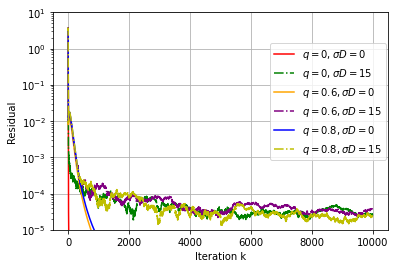

In [29]:
# Convergence plot

start=1
y_axis = np.random.normal(loc=0.5, scale=0.4, size=1000)
y_axis = y_axis[(y_axis > 0) & (y_axis < 1)]
y_axis.sort()    
plt.clf()
plt.yscale('log')
plt.grid()
plt.ylim((1e-5, 10))


plt.plot(loss_z_cons_fd[:10000], color='r', linestyle="-", label =r"$q = 0, \sigma D = 0$")
plt.plot(loss_z_cons_rd1[:10000], color='g', linestyle="-.", label =r"$q = 0, \sigma D = 15$")
plt.plot(loss_z_cons_rd4[:10000], color='orange', linestyle="-", label =r"$q = 0.6, \sigma D = 0$")
plt.plot(loss_z_cons_rd5[:10000], color='purple', linestyle="-.", label =r"$q = 0.6, \sigma D = 15$")
plt.plot(loss_z_cons_rd2[:10000], color='b', linestyle="-", label =r"$q = 0.8, \sigma D = 0$")
plt.plot(loss_z_cons_rd3[:10000], color='y', linestyle="-.", label =r"$q = 0.8, \sigma D = 15$")


plt.xlabel('Iteration k')
plt.ylabel('Residual')
# plt.legend()
plt.legend(bbox_to_anchor=(1.01,0.88),loc='upper right')

#print(LA.norm(x_star, 'fro'))
#plt.savefig('/tmp/linear_res.eps',dpi=600,format='eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


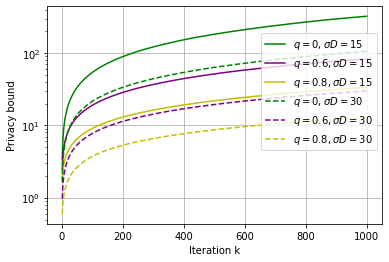

In [6]:
# Privacy bound and plot

sigma = 2
steps_list = np.linspace(start=1, stop=1000, num=1000)
noise_multiplier1 = 1.5 # sigma=noise_multiplier * D
noise_multiplier2 = 3
# sampling_probability = 0.5
delta = 1e-5

'''
y1 =[compute_epsilon(steps = st,
                    noise_multiplier=noise_multiplier1,
                    sampling_probability=1,
                    delta=delta) for st in steps_list]

y2 =[compute_epsilon(steps = st,
                    noise_multiplier=noise_multiplier1,
                    sampling_probability=0.4,
                    delta=delta) for st in steps_list]

y3 =[compute_epsilon(steps = st,
                    noise_multiplier=noise_multiplier1,
                    sampling_probability=0.2,
                    delta=delta) for st in steps_list]

y4 =[compute_epsilon(steps = st,
                    noise_multiplier=noise_multiplier2,
                    sampling_probability=1,
                    delta=delta) for st in steps_list]

y5 =[compute_epsilon(steps = st,
                    noise_multiplier=noise_multiplier2,
                    sampling_probability=0.4,
                    delta=delta) for st in steps_list]

y6 =[compute_epsilon(steps = st,
                    noise_multiplier=noise_multiplier2,
                    sampling_probability=0.2,
                    delta=delta) for st in steps_list]
'''


start=1
y_axis = np.random.normal(loc=0.5, scale=0.4, size=1000)
y_axis = y_axis[(y_axis > 0) & (y_axis < 1)]
y_axis.sort()    
plt.clf()
plt.yscale('log')
plt.grid()

plt.plot(steps_list, y1, color='g', linestyle="-", label =r"$q = 0, \sigma D = 15$")
plt.plot(steps_list, y2, color='purple', linestyle="-", label =r"$q = 0.6, \sigma D= 15$")
plt.plot(steps_list, y3, color='y', linestyle="-", label =r"$q = 0.8, \sigma D = 15$")
plt.plot(steps_list, y4, color='g', linestyle="--", label =r"$q = 0, \sigma D = 30$")
plt.plot(steps_list, y5, color='purple', linestyle="--", label =r"$q = 0.6, \sigma D = 30$")
plt.plot(steps_list, y6, color='y', linestyle="--", label =r"$q = 0.8, \sigma D = 30$")

plt.xlabel('Iteration k')
plt.ylabel('Privacy bound')
# plt.legend()
plt.legend(bbox_to_anchor=(1.0,0.9),loc='upper right')

plt.savefig('/tmp/linear_res_pri.eps',dpi=600,format='eps')